In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# %matplotlib widget
# %matplotlib agg
 
import numpy as np
import os,pickle,sys,fnmatch,shutil,yaml
from os.path import join
from pathlib import Path
import time

import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rc('text', usetex=False)

In [2]:
class TIFF():
    "This class stores all information associated with tiff file generated by xpdAcq"
    
    def __init__(self,
                 abspath,
                 samplename,
                 read_meta=True,
                 read_img=False, read_mask=False,
                 read_integration=True,read_sq=True,read_fq=True,read_gr=True,
                 save_npz=False):
        super(TIFF, self).__init__()
        
        
        try:
            suffix = Path(abspath).suffix
            filename = Path(abspath).name.split(suffix)[0]
            parent = str(Path(abspath).parent)

            datetime = filename.split(samplename)[1].split('_')[1]
            timestamp = int(time.mktime(time.strptime(datetime, '%Y%m%d-%H%M%S')))

            if filename.endswith('_dark_corrected_img'):
                ind = filename.split('_')[-4]
                meta_id = filename.split('_')[-5]
                if filename.split('_')[-6] == datetime:
                    dx = None
                    dy = None
            else:
                ind = filename.split('_')[-1]
                meta_id = filename.split('_')[-2]
                if filename.split('_')[-6] == datetime:
                    dx = None
                    dy = None
                else:
                    if filename.split(datetime)[1].startswith('_dx'):
                        dx = float(filename.split(datetime)[1].split('_dx_')[1].split('mm')[0])
                        try:
                            dy = float(filename.split(datetime)[1].split('_dy_')[1].split('mm')[0])
                        except:
                            dy = None

            self.info = {
                'abspath':abspath,
                'suffix':suffix,
                'parent':parent,
                'filename':filename,
                'datetime':datetime,
                'timestamp':timestamp,
                'ind':ind,
                'meta_id':meta_id,
                'dx':dx,
                'dy':dy        
            }
        except Exception as exc:
            print('TIFF ERROR: unable to read basic information'+
                  ' from tiff file! \n______ %s' % (exc))
        
        if read_meta:
            try:
                if self.info['filename'].endswith('_dark_corrected_img'):
                    self.meta = yaml.load(open(join(self.info['parent'],'..','meta',
                                                self.info['filename'][0:-24]+'.yaml')))
                else:
                    self.meta = yaml.load(open(join(self.info['parent'],'..','meta',
                                                self.info['filename']+'.yaml'))) 
            except Exception as exc:
                self.meta = None
                print('TIFF ERROR: unable to read meta data!'+
                      '\n%s' % (exc))
        else:
            self.meta = None
        
            
        if read_img:
            import imageio 
            self.img = imageio.imread(abspath)   
            if read_mask: 
                if self.info['filename'].endswith('_dark_corrected_img'):
                    mask_file = join(self.info['parent'],'..','mask',self.info['filename'][0:-19]+'_mask.npy')
                else:
                    mask_file = join(self.info['parent'],'..','mask',self.info['filename']+'_mask.npy')
                try:
                    self.mask = np.load(mask_file)
                except Exception as exc:
                    print('TIFF ERROR: unable to read mask!'+
                      '\n%s' % (exc))  
                    
                    
        if read_integration:
            integration_dir = join(self.info['parent'],'..','integration')
            if os.path.isdir(integration_dir):
                itth_file = join(integration_dir,self.info['filename'][0:-19]+'_mean_tth.chi')
                self.itth = np.loadtxt(itth_file,unpack=True,comments=['#','\''], 
                                 usecols=(0,1), skiprows=8)
                iq_file = join(integration_dir,self.info['filename'][0:-19]+'_mean_q.chi')
                self.iq = np.loadtxt(iq_file,unpack=True,comments=['#','\''], 
                                 usecols=(0,1), skiprows=8)                                             
        if read_sq:
            sq_dir = join(self.info['parent'],'..','sq')
            if os.path.isdir(sq_dir):
                if self.info['filename'].endswith('_dark_corrected_img'):
                    sq_file = join(sq_dir,self.info['filename'][0:-19]+'.sq')
                else:
                    sq_file = join(sq_dir,self.info['filename']+'.sq')
                self.sq = np.loadtxt(sq_file,unpack=True,comments=['#','\''], 
                                 usecols=(0,1), skiprows=8)            
        if read_fq:
            fq_dir = join(self.info['parent'],'..','fq')
            if os.path.isdir(fq_dir):
                if self.info['filename'].endswith('_dark_corrected_img'):
                    fq_file = join(fq_dir,self.info['filename'][0:-19]+'.fq')
                else:
                    fq_file = join(fq_dir,self.info['filename']+'.fq')
                self.fq = np.loadtxt(fq_file,unpack=True,comments=['#','\''], 
                                 usecols=(0,1), skiprows=8)          
        if read_gr:
            pdf_dir = join(self.info['parent'],'..','pdf')
            if os.path.isdir(pdf_dir):
                if self.info['filename'].endswith('_dark_corrected_img'):
                    gr_file = join(pdf_dir,self.info['filename'][0:-19]+'.gr')
                else:
                    gr_file = join(pdf_dir,self.info['filename']+'.gr')
                self.gr = np.loadtxt(gr_file,unpack=True,comments=['#','\''], 
                                 usecols=(0,1), skiprows=8)  
                
            
    def __str__(self):
        print(self.info)
        return 'Tiff file from %s' % (self.info['abspath'])
                          

In [3]:
class SAMPLE():
    "This class stores samples"
    
    def __init__(self,
                 samplepath,
                 samplename=None,
                 tiff_ext='.tiff',
                 read_meta=True,
                 read_img=False, read_mask=False,
                 read_integration=True,read_sq=True,read_fq=True,read_gr=True,
                 save_npz=False):
        super(SAMPLE, self).__init__()
        
        self.samplepath = samplepath
        
        if samplename is None:
            self.samplename = Path(self.samplepath).name
        else:
            self.samplename = samplename
             
        tiff_list = []
        for file in os.listdir(join(samplepath,'dark_sub')):
            if fnmatch.fnmatch(file, '*'+tiff_ext):
                tiff_list.append(file)  

        tiffs = []
        for i in tiff_list:
            try:
                tiff = TIFF(join(samplepath,'dark_sub',i),self.samplename,
                                                  read_meta,
                                                  read_img,
                                                  read_mask,
                                                  read_integration,
                                                  read_sq,
                                                  read_fq,
                                                  read_gr,
                                                  save_npz)
                tiffs.append([tiff,tiff.info['timestamp']])
            except Exception as exc:
                print('SAMPLE ERROR: unable to read %s \n%s\n' % (i,exc)) 
        
        tiffs.sort(key=lambda x: x[1])   
        
        self.tiffs = [i[0] for i in tiffs]
        

def plotter1(smpl,ind,y_bottom=None,vmax=100):
    fig = plt.figure(figsize=(8,8))

    ax = fig.add_subplot('221')
    ax.imshow(smpl.tiffs[ind].img,vmin=1,vmax=vmax)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title('{:s}'.format(smpl.samplename), fontsize=15) 

    ax = fig.add_subplot('222')
    ax.imshow(smpl.tiffs[ind].mask)
    ax.axis('off')
    ax.set_title('mask')
    
    ax = fig.add_subplot('212')
    ax.plot(smpl.tiffs[ind].iq[0],smpl.tiffs[ind].iq[1])
#     ax.set_yscale('log')

    ax.set_ylim(bottom=y_bottom)
    
    ax.set_xlabel(u'Q ($\AA^{-1}$)', fontsize=10, weight='normal')
    ax.set_ylabel(u'Intensity', fontsize=10, weight='normal')  
    
    if smpl.tiffs[ind].meta:
        fltr = smpl.tiffs[ind].meta['filter_positions']
        filterstr='%s-%s-%s-%s' %(fltr['flt1'],fltr['flt2'],fltr['flt3'],fltr['flt4'])
        textstr = 'exposure=%.1fsec.   tpf=%.1f   filters: %s '%(smpl.tiffs[ind].meta['sp_computed_exposure'],
                                                  smpl.tiffs[ind].meta['sp_time_per_frame'],
                                                  filterstr)
        props = dict(boxstyle='none', facecolor='wheat', alpha=0.5)    
        ax.text(0.0, 1.1, textstr, transform=ax.transAxes, fontsize=12,verticalalignment='top')

    plt.tight_layout()

TIFF ERROR: unable to read meta data!
[Errno 2] No such file or directory: '/home/mt/temp/tucker/tiff_base/Kapton_disc_PDF/dark_sub/../meta/Kapton_disc_PDF_20190307-144426_a82c28.yaml'


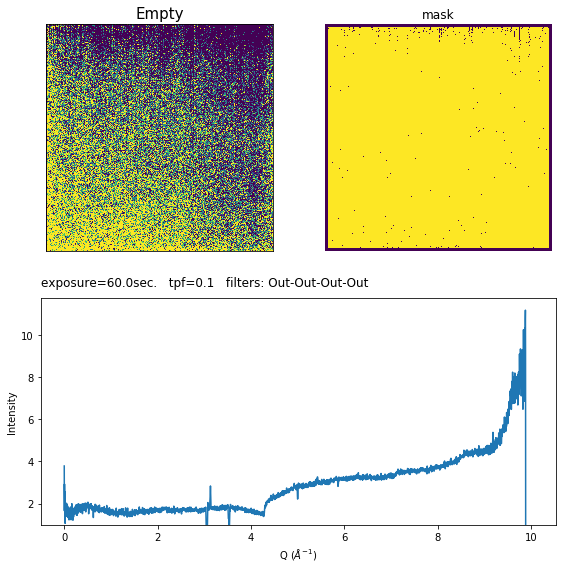

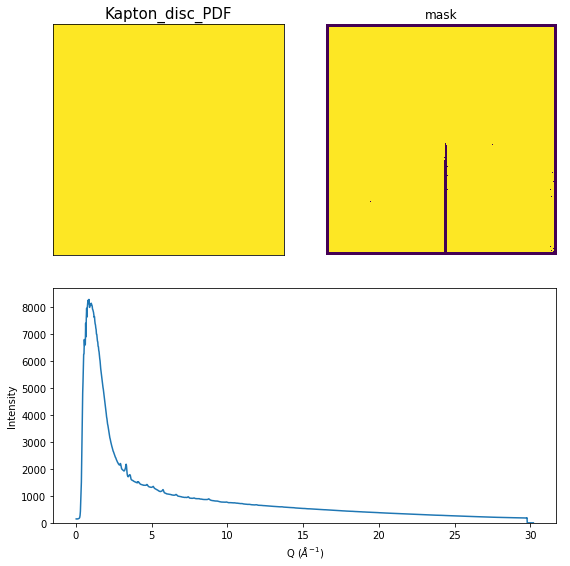

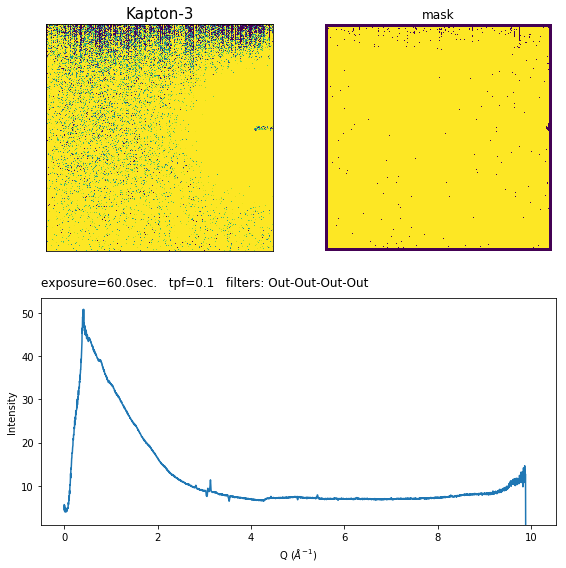

In [6]:
# Phil PDF

samplepath = '/home/mt/temp/tucker/tiff_base/Empty/'
smpl = SAMPLE(samplepath,read_img=True, read_mask=True)
plotter1(smpl,ind=0,y_bottom=1,vmax=5) 

samplepath = '/home/mt/temp/tucker/tiff_base/Kapton_disc_PDF'
smpl = SAMPLE(samplepath,read_img=True, read_mask=True)
plotter1(smpl,ind=0,y_bottom=1,vmax=5) 

samplepath = '/home/mt/temp/tucker/tiff_base/Kapton-3'
smpl = SAMPLE(samplepath,read_img=True, read_mask=True)
plotter1(smpl,ind=0,y_bottom=1,vmax=5) 

In [6]:
samplepath = '/home/mt/temp/tucker/tiff_base/LaB6_disc_2min'
smpl = SAMPLE(samplepath,read_img=True, read_mask=True)
plotter1(smpl,ind=0,y_bottom=1,vmax=50) 
smpl.tiffs[0].meta['sp_computed_exposure']

FigureCanvasNbAgg()

60.0

TIFF ERROR: unable to read meta data!
[Errno 2] No such file or directory: '/home/mt/temp/home/xf28id2/mehmet/xpdUser/tiff_base/Setup/dark_sub/../meta/Setup_20190307-161151_610e05.yaml'
TIFF ERROR: unable to read meta data!
[Errno 2] No such file or directory: '/home/mt/temp/home/xf28id2/mehmet/xpdUser/tiff_base/Setup/dark_sub/../meta/Setup_20190307-161152_4aa35a.yaml'


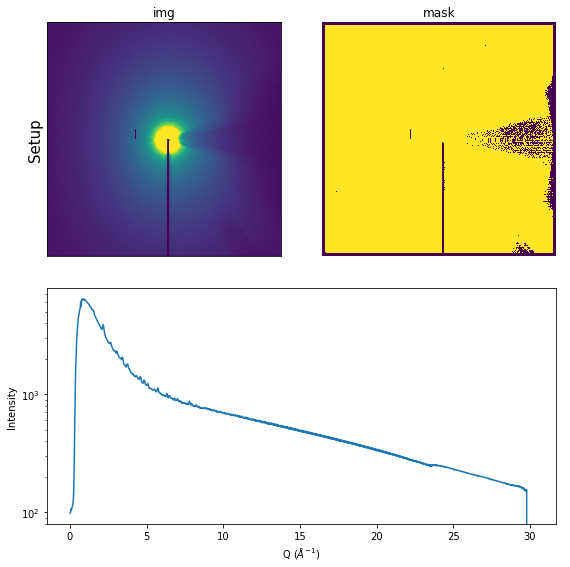

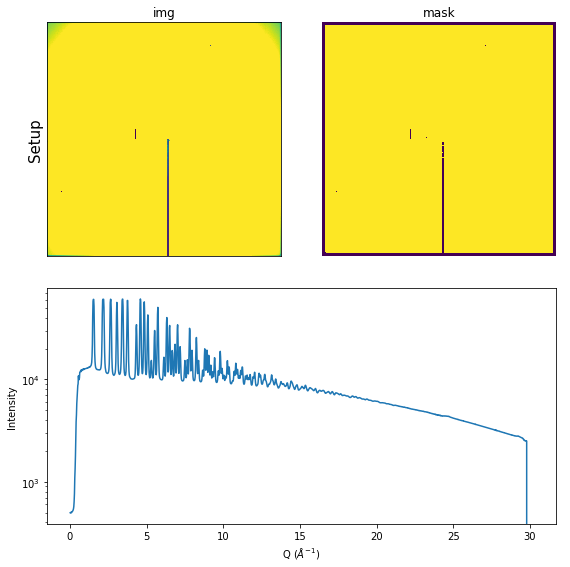

In [179]:
samplepath = '/home/mt/temp/home/xf28id2/mehmet/xpdUser/tiff_base/Setup'
smpl = SAMPLE(samplepath,read_img=True, read_mask=True)
for e,i in enumerate(smpl.tiffs):
    plotter1(smpl,ind=e) 

TIFF ERROR: unable to read meta data!
[Errno 2] No such file or directory: '/home/mt/temp/home/xf28id2/mehmet/xpdUser/tiff_base/LaB6/dark_sub/../meta/LaB6_20190307-161153_c0cf29.yaml'
TIFF ERROR: unable to read mask!
[Errno 2] No such file or directory: '/home/mt/temp/home/xf28id2/mehmet/xpdUser/tiff_base/LaB6/dark_sub/../mask/LaB6_20190307-161153_c0cf29_0001_mask.npy'
SAMPLE ERROR: unable to read LaB6_20190307-161153_c0cf29_0001_dark_corrected_img.tiff 
/home/mt/temp/home/xf28id2/mehmet/xpdUser/tiff_base/LaB6/dark_sub/../integration/LaB6_20190307-161153_c0cf29_0001_mean_tth.chi not found.

TIFF ERROR: unable to read meta data!
[Errno 2] No such file or directory: '/home/mt/temp/home/xf28id2/mehmet/xpdUser/tiff_base/LaB6/dark_sub/../meta/LaB6_20190307-161212_98560a.yaml'
TIFF ERROR: unable to read mask!
[Errno 2] No such file or directory: '/home/mt/temp/home/xf28id2/mehmet/xpdUser/tiff_base/LaB6/dark_sub/../mask/LaB6_20190307-161212_98560a_0001_mask.npy'
SAMPLE ERROR: unable to read L

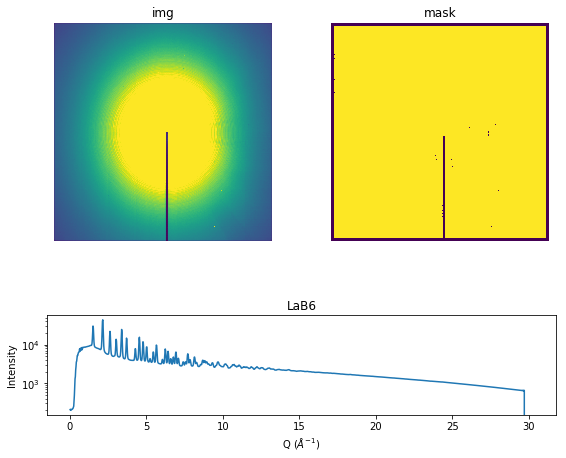

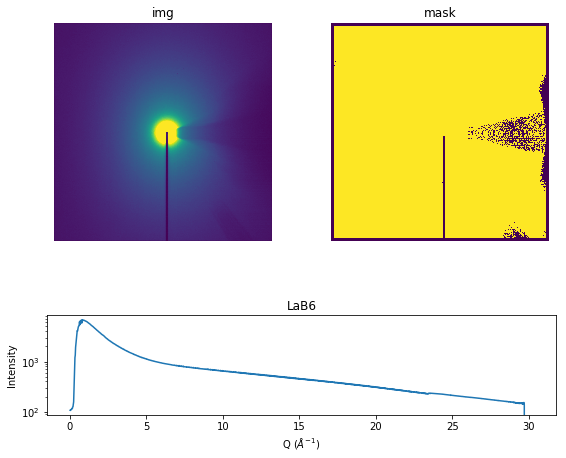

In [80]:
samplepath = '/home/mt/temp/home/xf28id2/mehmet/xpdUser/tiff_base/LaB6'
smpl = SAMPLE(samplepath,read_img=True, read_mask=True)
for e,i in enumerate(smpl.tiffs):
    plotter1(smpl,ind=e) 

In [79]:
samplepath = '/home/mt/temp/home/xf28id2/mehmet/xpdUser/tiff_base/LaB6-try2'
samplename = 'LaB6-try2'
smpl = SAMPLE(samplepath,samplename,read_img=True, read_mask=True)
for e,i in enumerate(smpl.tiffs):
    plotter1(smpl,ind=e) 

TIFF ERROR: unable to read meta data!
[Errno 2] No such file or directory: '/home/mt/temp/home/xf28id2/mehmet/xpdUser/tiff_base/LaB6-try2/dark_sub/../meta/LaB6-try2_20190307-204650_6a4aa5.yaml'
TIFF ERROR: unable to read mask!
[Errno 2] No such file or directory: '/home/mt/temp/home/xf28id2/mehmet/xpdUser/tiff_base/LaB6-try2/dark_sub/../mask/LaB6-try2_20190307-204650_6a4aa5_0001_mask.npy'
SAMPLE ERROR: unable to read LaB6-try2_20190307-204650_6a4aa5_0001_dark_corrected_img.tiff 
/home/mt/temp/home/xf28id2/mehmet/xpdUser/tiff_base/LaB6-try2/dark_sub/../integration/LaB6-try2_20190307-204650_6a4aa5_0001_mean_tth.chi not found.



{'analysis_stage': 'meta', 'beamline_config': {'Filters': ['1Cu', '2Cu', '3Cu', '4Cu'], 'Verification time': '2019-03-07 19:55:56', 'Verified by': 'MT', 'beamstop': 'W', 'filter_attenuation': [2.1340162185232607, 4.504504504504505, 9.523809523809524, 20.74688796680498]}, 'beamline_id': '28-id-2', 'bt_experimenters': ['Mehmet', 'Topsakal', 'David', 'Sprouster', 'Igor', 'Gussev', 'Devon', 'Drey'], 'bt_piLast': 'Ecker', 'bt_safN': '303782', 'bt_uid': '84dc5934', 'bt_wavelength': 0.18754, 'calibration_md': {'calibrant_name': 'undefined', 'centerX': 1062.3637334875552, 'centerY': 1033.200279257563, 'dSpacing': [4.156826, 2.93931985, 2.39994461, 2.078413, 1.8589891, 1.69701711, 1.46965993, 1.38560867, 1.3145038, 1.2533302, 1.19997231, 1.1528961, 1.11095848, 1.0392065, 1.00817839, 0.97977328, 0.95364129, 0.92949455, 0.9070938, 0.88623828, 0.84850855, 0.8313652, 0.81522065, 0.79998154, 0.77190321, 0.75892912, 0.73482996, 0.72361053, 0.71288978, 0.70263184, 0.69280433, 0.68337798, 0.67432622, 0

ValueError: x and y must have same first dimension, but have shapes (2095,) and (2094,)

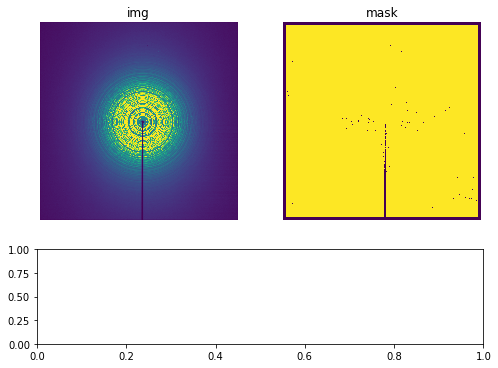

In [90]:
samplepath = '/home/mt/temp/home/xf28id2/mehmet/xpdUser/tiff_base/SrMoO4'
smpl = SAMPLE(samplepath,read_img=True, read_mask=True)
plotter1(smpl,ind=0) 